# Предсказание температуры звёзд

## Цель

С помощью нейросети определять температуру поверхности звёзд.

## Задачи

1. Построить простые модели нейронных сетей и изучить их предсказательные способности на имеющихся данных
2. Оптимизировать одну из имеющихся моделей с целью повышения качества её прогнозов с тем, чтобы добиться среднеквадратичной ошибки ниже 4500 К

In [3]:
import warnings
from copy import deepcopy
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [4]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None

sns.set(rc={"figure.figsize": (12, 8)})

warnings.filterwarnings("ignore")

## Загрузка данных

In [5]:
try:
    df = pd.read_csv("/datasets/6_class.csv")
except FileNotFoundError:
    df = pd.read_csv("./6_class.csv", index_col=0)

In [6]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,2.40e-03,0.17,16.12,0,Red
1,1,3042,5.00e-04,0.15,16.60,0,Red
2,2,2600,3.00e-04,0.10,18.70,0,Red
3,3,2800,2.00e-04,0.16,16.65,0,Red
4,4,1939,1.38e-04,0.10,20.06,0,Red


Обращает на себя внимание дублирование индексного столбца. От дубля следует избавиться

In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Данные загрузил и удалил ненужный столбец, отлично:)</div>

In [8]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00,2.40e+02,2.40e+02,240.00,240.00
mean,10497.46,1.07e+05,2.37e+02,4.38,2.50
std,9552.43,1.79e+05,5.17e+02,10.53,1.71
min,1939.00,8.00e-05,8.40e-03,-11.92,0.00
25%,3344.25,8.65e-04,1.03e-01,-6.23,1.00
50%,5776.00,7.05e-02,7.62e-01,8.31,2.50
75%,15055.50,1.98e+05,4.28e+01,13.70,4.00
max,40000.00,8.49e+05,1.95e+03,20.06,5.00


Пропуски в данных отсутствуют. На первый взгляд аномальных значений так же не видно.

## Предобработка и анализ данных

При первичном ознакомлении с данными, аномалии не бросались в глаза. Но чтобы в этом убедиться, стоит построить графики распределений признаков. Желательно в разбивке по типам звёзд: светимости и радиусы гигантов и карликов должны совершенно точно различаться.

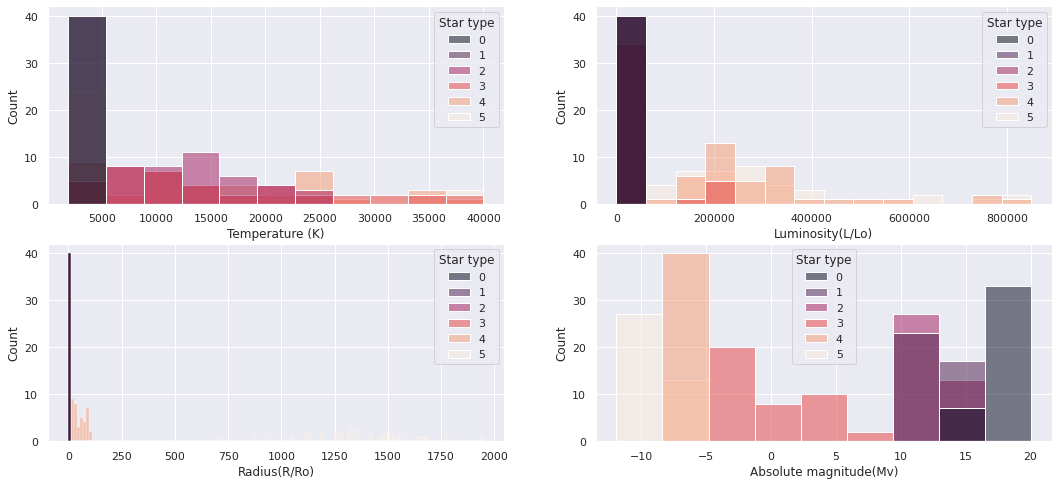

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8))
sns.histplot(
    ax=axs[0][0],
    data=df,
    x="Temperature (K)",
    hue="Star type",
    palette="rocket",
)
sns.histplot(
    ax=axs[0][1],
    data=df,
    x="Luminosity(L/Lo)",
    hue="Star type",
    palette="rocket",
)
sns.histplot(
    ax=axs[1][0],
    data=df,
    x="Radius(R/Ro)",
    hue="Star type",
    palette="rocket",
)
sns.histplot(
    ax=axs[1][1],
    data=df,
    x="Absolute magnitude(Mv)",
    hue="Star type",
    palette="rocket",
);

Наконец, надо посмотреть распределение звёзд по цветам:

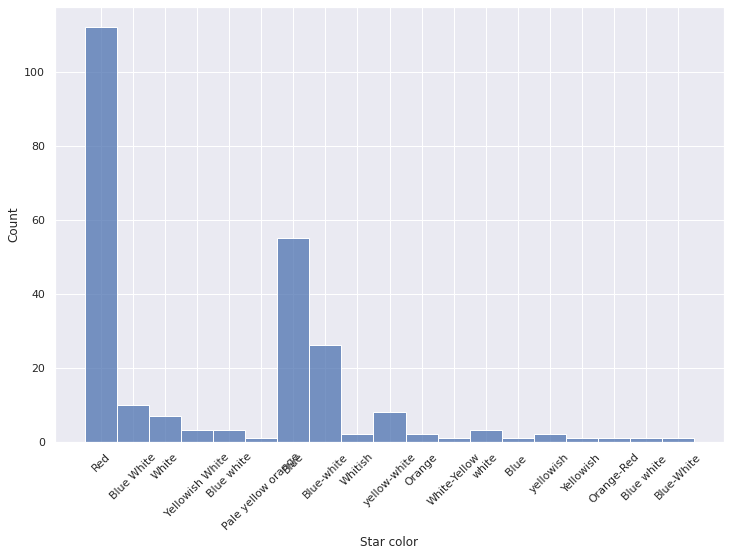

In [10]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.histplot(
    ax=axs,
    data=df,
    x="Star color",
    palette="rocket",
)
plt.xticks(rotation=45);

В соответствие с распределением звёзд во Вселенной, в нашей выборке превалируют красные карлики: на графиках температур, светимостей и радиусов имеется тёмный выброс слева, соответсвующий карликам. На графике цветов красных звёзд также много. Крупных и горячих звёзд заметно меньше.

Прежде чем приступать к построению нейросети и её обучению, нужно нормализовать данные.

У нас есть пара категориальных признаков - цвет и тип, остальные - числовые.

С цветом есть проблемы:

In [11]:
df["Star color"].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Видно, что ряд цветов повторяется из-за лишних пробелов, регистра букв и замены пробела и дефиса

In [12]:
df["Star color"] = df["Star color"].apply(
    lambda x: x.strip().lower().replace(" ", "_").replace("-", "_")
)

In [13]:
df["Star color"].unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'yellow_white', 'orange',
       'white_yellow', 'yellowish', 'orange_red'], dtype=object)

И последний штрих:

In [14]:
df.loc[df["Star color"] == "white_yellow", "Star color"] = "yellow_white"

Перед разделением обучающей и валидационной выборок преобразуем категориальные признаки: наша задача, чтобы все возможные значения категориальных признаков были известны трансформеру, иначе он не сможет преобразовать данные.

In [15]:
ohe = make_column_transformer(
    (OneHotEncoder(sparse=False), ["Star type", "Star color"]),
    remainder="passthrough",
)
df = pd.DataFrame(ohe.fit_transform(df), columns=ohe.get_feature_names())

In [16]:
df.head()

,onehotencoder__x0_0,onehotencoder__x0_1,onehotencoder__x0_2,onehotencoder__x0_3,onehotencoder__x0_4,onehotencoder__x0_5,onehotencoder__x1_blue,onehotencoder__x1_blue_white,onehotencoder__x1_orange,onehotencoder__x1_orange_red,onehotencoder__x1_pale_yellow_orange,onehotencoder__x1_red,onehotencoder__x1_white,onehotencoder__x1_whitish,onehotencoder__x1_yellow_white,onehotencoder__x1_yellowish,onehotencoder__x1_yellowish_white,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3068.0,2.40e-03,0.17,16.12
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3042.0,5.00e-04,0.15,16.60
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2600.0,3.00e-04,0.10,18.70
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2800.0,2.00e-04,0.16,16.65
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1939.0,1.38e-04,0.10,20.06


В принципе, странные имена признаков не являются препятствием для обучения, но выглядят уродливо, причешем их:

In [17]:
columns = []
for c in ohe.get_feature_names():
    if c.startswith("onehotencoder__x0"):
        columns.append("star_type" + c[17:])
    elif c.startswith("onehotencoder__x1"):
        columns.append("star_color" + c[17:])
    else:
        columns.append(c)
df.columns = columns

In [18]:
X = df.drop(["Temperature (K)"], axis=1)
y = df["Temperature (K)"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
scaler = StandardScaler()

In [20]:
columns = [
    "Luminosity(L/Lo)",
    "Radius(R/Ro)",
    "Absolute magnitude(Mv)",
]
X_train[columns] = scaler.fit_transform(X_train[columns])
X_test[columns] = scaler.transform(X_test[columns])

In [21]:
y_train.head()

139     3541.0
60      3341.0
204    18340.0
186     2968.0
207    23092.0
Name: Temperature (K), dtype: float64

In [22]:
X_train.head()

,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue,star_color_blue_white,star_color_orange,star_color_orange_red,star_color_pale_yellow_orange,star_color_red,star_color_white,star_color_whitish,star_color_yellow_white,star_color_yellowish,star_color_yellowish_white,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
139,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.58,-0.43,0.92
60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.58,-0.43,1.11
204,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.58,-0.43,0.62
186,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.58,-0.43,1.22
207,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.58,-0.43,0.52


Осталось преобразовать датафреймы в тензоры:

In [23]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

## Построение базовой нейронной сети

Построим простую нейронную сеть, которая будет предсказывать температуру звезды по прочим признакам. Модель наша будет предсказывать один количественный признак, так что выходной слой будет состоять из одного нейрона с функцией активации ReLU или ей подобными. Признаков у нас 20, это определяет число нейронов на входе. Для начала построим простейшую сеть с одним скрытым слоем, равным входному

In [24]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_normal_(layer.weight, mode="fan_in", nonlinearity="relu")
        nn.init.normal_(layer.bias, 1, 1)

In [25]:
num_features = 20
n_hidden_neurons_1 = 10
n_out_neurons = 1


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, n_hidden_neurons_1),
            #             nn.BatchNorm1d(n_hidden_neurons_1),
            #             nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_out_neurons),
        )

    def forward(self, inputs):
        return self.layers(inputs)

In [24]:
net = Net()
net.layers.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=1)
loss = nn.MSELoss()
num_epochs = 1000
best_net = None
best_epoch = -1
best_rmse = 1e10

errors = pd.DataFrame(columns=["train", "test"])

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    preds = net(X_train).flatten()

    loss_value = loss(preds, y_train)
    loss_value.backward()

    optimizer.step()

    net.eval()
    train_preds = net.forward(X_train)
    test_preds = net.forward(X_test)
    rmse = mean_squared_error(y_test, test_preds.detach().numpy()) ** 0.5
    errors.at[epoch, "train"] = (
        mean_squared_error(y_train, train_preds.detach().numpy()) ** 0.5
    )
    errors.at[epoch, "test"] = rmse
    if best_rmse > rmse:
        best_net = net
        best_epoch = epoch
        best_rmse = rmse

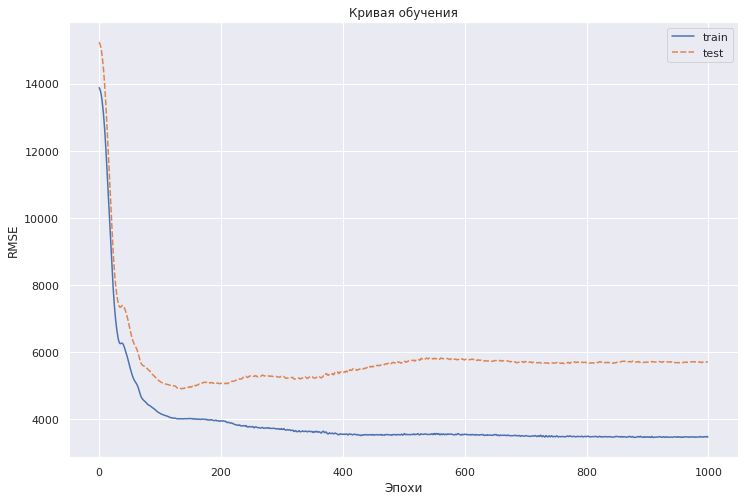

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=errors, ax=ax).set(
    title="Кривая обучения", xlabel="Эпохи", ylabel="RMSE"
);

In [26]:
pred_fact = pd.DataFrame(y_test.numpy(), columns=["fact"])
pred_fact["prediction"] = best_net.forward(X_test).detach().numpy()
pred_fact.head()

,fact,prediction
0,16500.0,14855.40
1,2637.0,2944.93
2,4980.0,4439.46
3,33421.0,13585.50
4,11096.0,21203.28


In [27]:
best_epoch

910

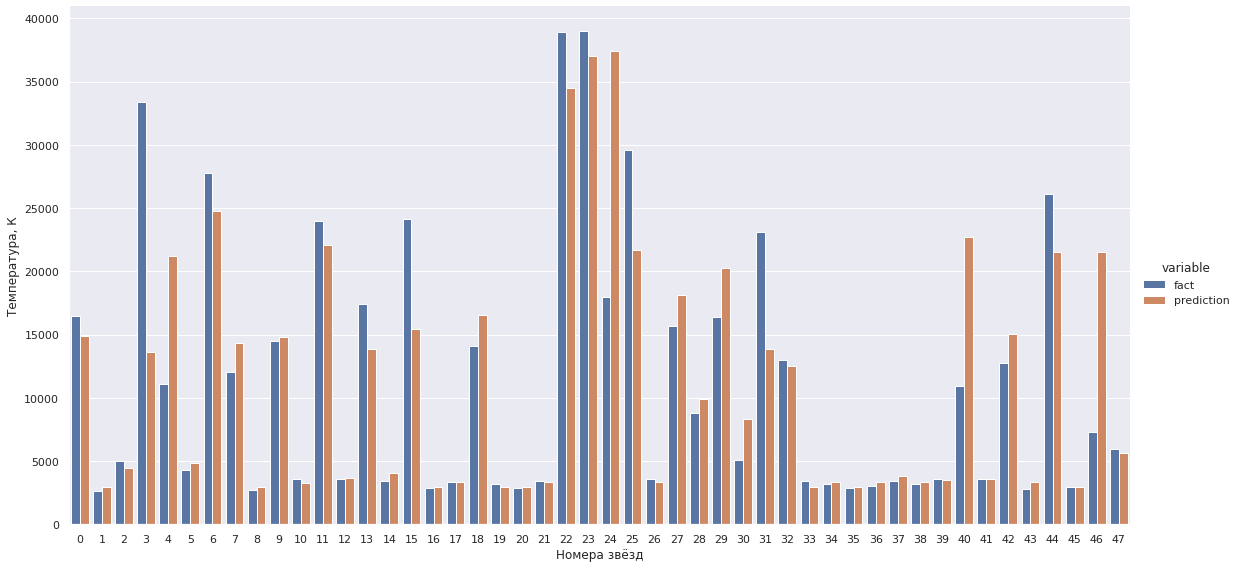

In [28]:
sns.factorplot(
    data=pd.melt(pred_fact.reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    ax=ax,
    kind="bar",
    size=8,
    aspect=2,
).set(xlabel="Номера звёзд", ylabel="Температура, К");

Ложбина на кривой обучения не очень выражена и пришлась на примерно 900ю эпоху. Дальше ошибки на обеих выборках начинают расти. Увы, ошибка на тестовой выборке начинает расти ссущественно раньше, что указывает на переобучение.

Добавим ещё один скрытый слой.

In [29]:
num_features = 20
n_hidden_neurons_1 = 20
n_hidden_neurons_2 = 10
n_out_neurons = 1


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_2, n_out_neurons),
        )

    def forward(self, inputs):
        return self.layers(inputs)

In [30]:
%%time

net = Net()
net.layers.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss = nn.MSELoss()

num_epochs = 5000
best_net = None
best_epoch = -1
best_rmse = 1e10

errors = pd.DataFrame(columns=["train", "test"])

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    preds = net(X_train).flatten()

    loss_value = loss(preds, y_train)
    loss_value.backward()

    optimizer.step()

    if epoch % 10 == 0:
        net.eval()
        train_preds = net.forward(X_train)
        test_preds = net.forward(X_test)
        errors.at[epoch, "train"] = (
            mean_squared_error(y_train, train_preds.detach().numpy()) ** 0.5
        )
        rmse = mean_squared_error(y_test, test_preds.detach().numpy()) ** 0.5
        errors.at[epoch, "test"] = rmse
        if best_rmse > rmse:
            best_net = net
            best_epoch = epoch
            best_rmse = rmse

CPU times: user 19.2 s, sys: 24.5 ms, total: 19.3 s
Wall time: 3.21 s


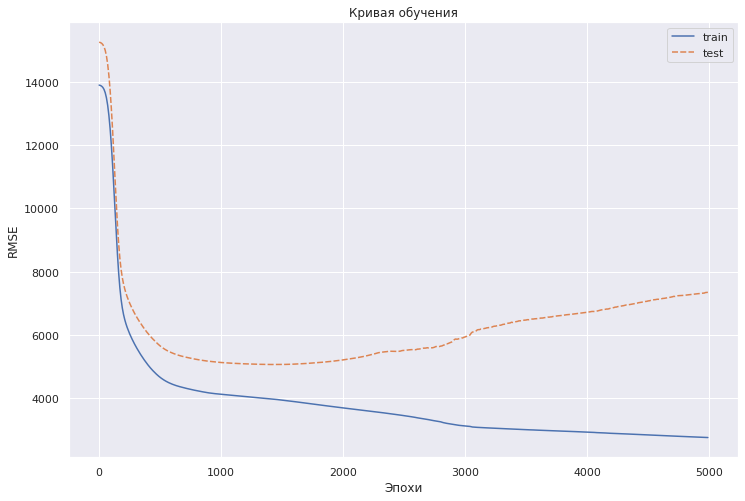

In [31]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.lineplot(data=errors, ax=axs).set(
    title="Кривая обучения", xlabel="Эпохи", ylabel="RMSE"
);

Та же самая картина: после примерно 1,5 тысчя эпох ошибка на валидационном наборе данных умтремляется вверх, указывая на переобучение, тогда как на тренировочных данных ошибка продолжает снижаться и после 5000 эпох.

In [32]:
pred_fact = pd.DataFrame(y_test.numpy(), columns=["fact"])
pred_fact["prediction"] = best_net.forward(X_test).detach().numpy()
pred_fact.head()

,fact,prediction
0,16500.0,14416.24
1,2637.0,2978.69
2,4980.0,5591.44
3,33421.0,12999.04
4,11096.0,26064.08


In [33]:
best_epoch

2000

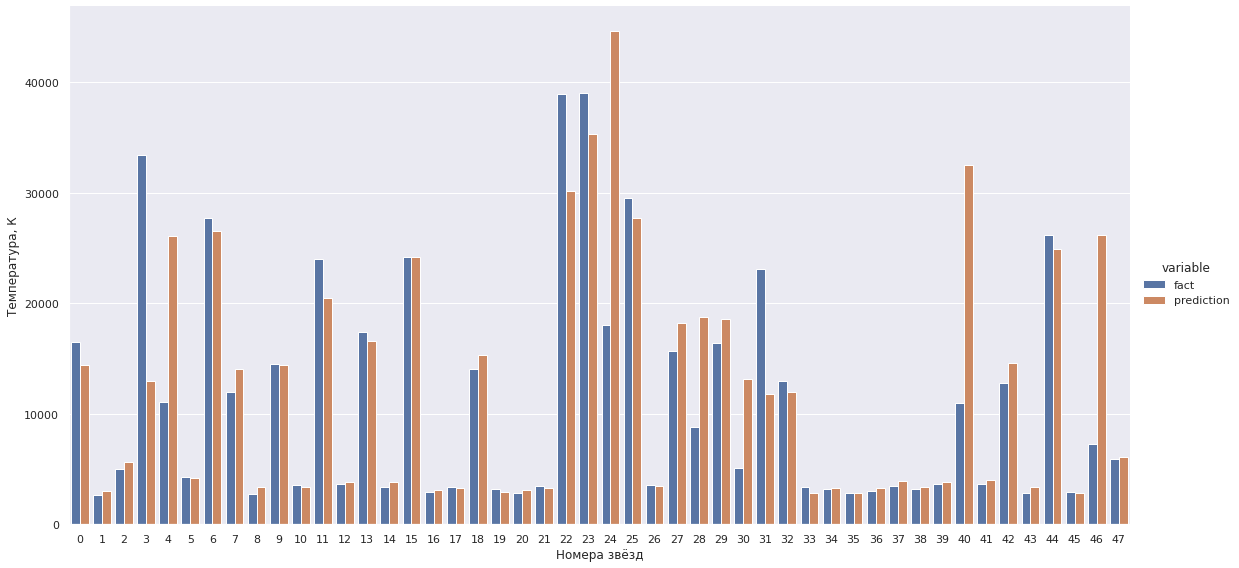

In [34]:
sns.factorplot(
    data=pd.melt(pred_fact.reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    ax=ax,
    kind="bar",
    size=8,
    aspect=2,
).set(xlabel="Номера звёзд", ylabel="Температура, К");

Модель обучается и достигает оптимума примерно на 2-тысячной эпохе. Проблема в том, что ошибка её предсказания не особо уменьшилась в сравнении с простой сетью с 1 скрытым слоем.

Посмотрим, что нам даст добавление третьего слоя

In [35]:
num_features = 20
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_hidden_neurons_3 = 3
n_out_neurons = 1


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, n_hidden_neurons_1),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_3, n_out_neurons),
        )

    def forward(self, inputs):
        return self.layers(inputs)

In [36]:
%%time

net = Net()
net.layers.apply(init_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss = nn.MSELoss()

num_epochs = 2500
best_net = None
best_epoch = -1
best_rmse = 1e10

errors = pd.DataFrame(columns=["train", "test"])

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    preds = net(X_train).flatten()

    loss_value = loss(preds, y_train)
    loss_value.backward()

    optimizer.step()

    if epoch % 1 == 0:
        net.eval()
        train_preds = net.forward(X_train)
        test_preds = net.forward(X_test)
        errors.at[epoch, "train"] = (
            mean_squared_error(y_train, train_preds.detach().numpy()) ** 0.5
        )
        rmse = mean_squared_error(y_test, test_preds.detach().numpy()) ** 0.5
        errors.at[epoch, "test"] = rmse

        if best_rmse > rmse:
            best_net = net
            best_epoch = epoch
            best_rmse = rmse

CPU times: user 27.9 s, sys: 28.5 ms, total: 28 s
Wall time: 4.67 s


In [37]:
best_rmse

5013.843834823737

На текущий момент среднеквадратичная ошибка лучшего прогноза равна примерно 5000.

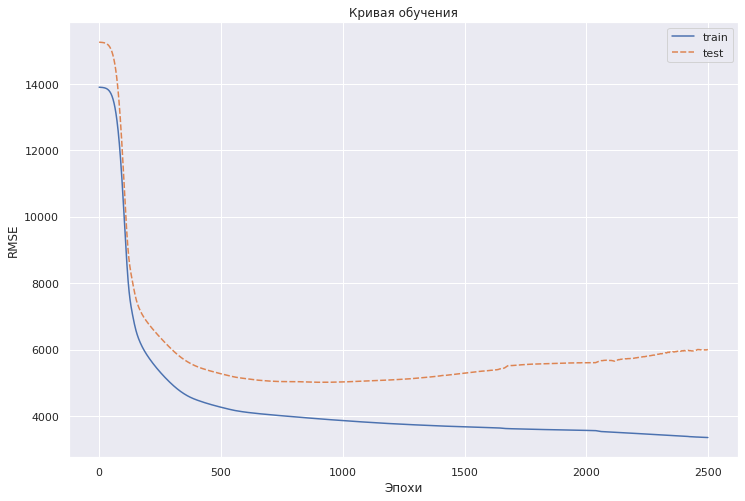

In [38]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.lineplot(data=errors, ax=axs).set(
    title="Кривая обучения", xlabel="Эпохи", ylabel="RMSE"
);

In [39]:
pred_fact = pd.DataFrame(y_test.numpy())
pred_fact.columns = ["fact"]
pred_fact["prediction"] = best_net(X_test).detach().numpy()
pred_fact.head()

,fact,prediction
0,16500.0,14083.82
1,2637.0,3029.78
2,4980.0,4629.58
3,33421.0,14199.34
4,11096.0,22948.27


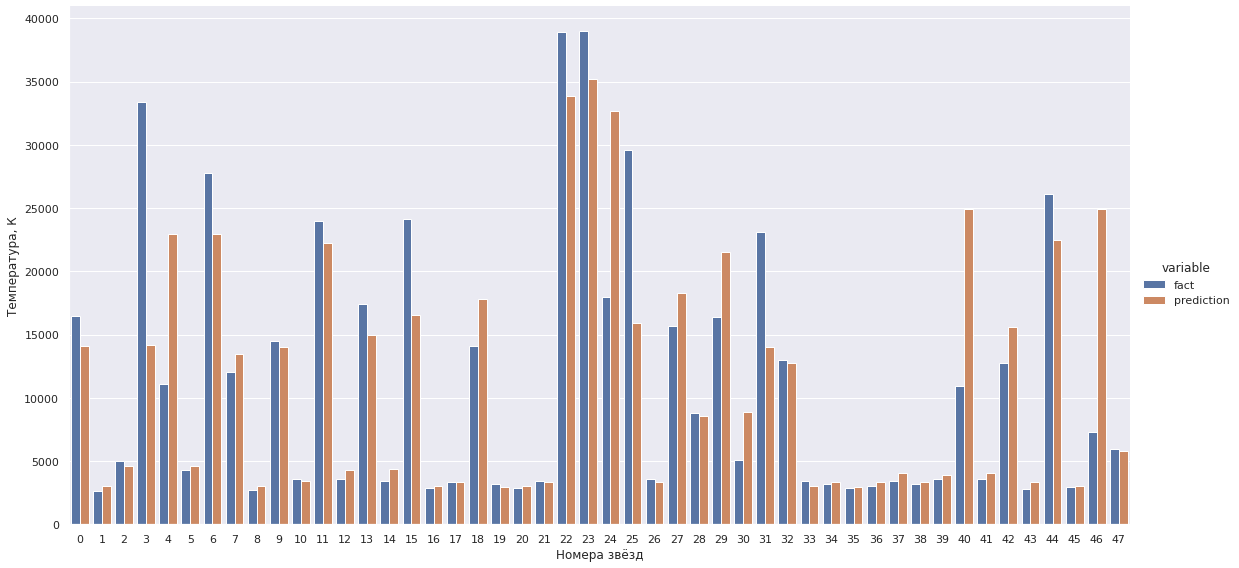

In [40]:
sns.factorplot(
    data=pd.melt(pred_fact.reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    ax=ax,
    kind="bar",
    size=8,
    aspect=2,
).set(xlabel="Номера звёзд", ylabel="Температура, К");

## Улучшение нейронной сети

Займёмся тюнингом нашей нейросети: постараемся найти оптимальные параметы с тем, чтобы повысить точность прогноза в рамках зафиксированной архитектуры сети.

Для начала параметризуем нашу модель и функцию обучения с тем, чтобы было удобнее проводить перебор параметров. Введём в модель дополнительные слои: Dropout и BatchNorm 

In [41]:
num_features = 20
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_hidden_neurons_3 = 3
n_out_neurons = 1


class Net(nn.Module):
    def __init__(self, p1=0, p2=0, p3=0, b1=0, b2=0, b3=0):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, n_hidden_neurons_1),
            nn.Dropout(p1) if p1 > 0 and p1 < 1 else nn.Identity(),
            nn.BatchNorm1d(n_hidden_neurons_1) if b1 > 0 else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
            nn.Dropout(p2) if p2 > 0 and p2 < 1 else nn.Identity(),
            nn.BatchNorm1d(n_hidden_neurons_2) if b2 > 0 else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
            nn.Dropout(p3) if p3 > 0 and p3 < 1 else nn.Identity(),
            nn.BatchNorm1d(n_hidden_neurons_3) if b3 > 0 else nn.Identity(),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons_3, n_out_neurons),
        )

    def forward(self, inputs):
        return self.layers(inputs)

In [42]:
def train_net(
    num_epochs: int,
    p1=0,
    p2=0,
    p3=0,
    b1=0,
    b2=0,
    b3=0,
    test_step=10,
    batch_size=len(X_train),
):
    """функция для обучения нейросети с параметрами регуляризации"""
    best_rmse = 1e10
    best_net = None
    best_epoch = -1
    net = Net(p1, p2, p3, b1, b2, b3)
    net.layers.apply(init_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss = nn.MSELoss()

    num_batches = ceil(len(X_train) / batch_size)

    for epoch in range(num_epochs):
        net.train()
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            # получение индексов текущего батча
            batch_indexes = order[start_index : start_index + batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net(X_batch).flatten()

            loss_value = loss(preds, y_batch)
            loss_value.backward()

        optimizer.step()

        if epoch % test_step == 0:
            net.eval()
            test_preds = net(X_test)
            rmse = mean_squared_error(y_test, test_preds.detach().numpy()) ** 0.5
            if best_rmse > rmse:
                best_rmse = rmse
                best_net = net
                best_epoch = epoch
    return best_rmse, deepcopy(net), best_epoch

In [43]:
%%time

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss = nn.MSELoss()

optimisations = pd.DataFrame(
    columns=[
        "rmse",
        "p1",
        "p2",
        "p3",
        "b1",
        "b2",
        "b3",
        "batch",
        "best_epochs",
        "best_net",
    ],
    data=[],
)

L = X.shape[0]
for p1, b1 in [(0, 0), (0, 1), (0.25, 0), (0.5, 0), (0.75, 0)]:
    for p2, b2 in [(0, 0), (0, 1), (0.25, 0), (0.5, 0), (0.75, 0)]:
        for p3, b3 in [(0, 0), (0, 1), (0.25, 0), (0.5, 0), (0.75, 0)]:
            for batch in np.arange(0.25, 1 + 0.1, 0.25) * len(X_train):
                rmse, best_net, best_epochs = train_net(
                    3000, p1, p2, p3, b1, b2, b3, batch
                )
                optimisations = optimisations.append(
                    {
                        "rmse": rmse,
                        "best_epochs": best_epochs,
                        "batch": batch,
                        "best_net": best_net,
                        "p1": p1,
                        "p2": p2,
                        "p3": p3,
                        "b1": b1,
                        "b2": b2,
                        "b3": b3,
                    },
                    ignore_index=True,
                )

CPU times: user 2h 18min 57s, sys: 13.1 s, total: 2h 19min 10s
Wall time: 23min 17s


In [44]:
optimisations.rmse.min()

4640.522815373285

Уже после первого запуска мы получаем минимальную ошибку 4640 К

In [46]:
def highlight_min(s, props=""):
    return np.where(s < 5_000, props, "")


def highlight_max(s, props=""):
    return np.where(s > 10_000, props, "")


optimisations[
    ["rmse", "p1", "p2", "p3", "b1", "b2", "b3", "batch", "best_epochs"]
].style.applymap(highlight_min, props="color: green", subset=["rmse"]).applymap(
    highlight_max, props="color: red", subset=["rmse"]
)

,rmse,p1,p2,p3,b1,b2,b3,batch,best_epochs
0,15230.767282,0,0,0,0,0,0,48.000000,2976
1,4963.633548,0,0,0,0,0,0,96.000000,1440
2,5205.397007,0,0,0,0,0,0,144.000000,2304
3,4925.223041,0,0,0,0,0,0,192.000000,1152
4,8682.460481,0,0,0,0,0,1,48.000000,2832
5,10130.309373,0,0,0,0,0,1,96.000000,2976
6,12367.287819,0,0,0,0,0,1,144.000000,2880
7,10651.967330,0,0,0,0,0,1,192.000000,2880
8,15232.012080,0,0,0.250000,0,0,0,48.000000,2976
9,6056.528709,0,0,0.250000,0,0,0,96.000000,2304


Видно, что большинство значений параметров дают плохие результаты, но есть и обнадёживающие варианты

In [49]:
optimisations[optimisations["rmse"] < 4800][
    ["rmse", "p1", "p2", "p3", "b1", "b2", "b3", "batch", "best_epochs"]
]

,rmse,p1,p2,p3,b1,b2,b3,batch,best_epochs
100,4640.52,0,0,0,1,0,0,48.0,768
101,4689.23,0,0,0,1,0,0,96.0,672
102,4675.13,0,0,0,1,0,0,144.0,576
160,4788.29,0,0.5,0,1,0,0,48.0,912
323,4760.03,0.5,0,0,0,1,0,192.0,2304


Сузим круг поиска. Видно, что наилучшие результаты достигнуты при использовании BatchNorm на первом и, возможно, втором слое и при нулевом Dropout:

In [50]:
%%time

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss = nn.MSELoss()

optimisations = pd.DataFrame(
    columns=[
        "rmse",
        "p1",
        "p2",
        "p3",
        "b1",
        "b2",
        "b3",
        "batch",
        "best_epoch",
        "best_net",
    ],
    data=[],
)

L = X.shape[0]
for p2, b2 in [(0, 0), (0, 1), (0.1, 0), (0.2, 0), (0.3, 0)]:
    for batch in np.arange(0.25, 1 + 0.1, 0.1) * len(X_train):
        b1 = 1
        p1 = p3 = 0
        rmse, best_net, best_epoch = train_net(
            3000, p1, p2, p3, b1, b2, b3, test_step=1, batch_size=int(batch)
        )
        optimisations = optimisations.append(
            {
                "rmse": rmse,
                "best_epoch": best_epoch,
                "batch": batch,
                "best_net": best_net,
                "p1": p1,
                "p2": p2,
                "p3": p3,
                "b1": b1,
                "b2": b2,
                "b3": b3,
            },
            ignore_index=True,
        )

CPU times: user 27min 30s, sys: 3.55 s, total: 27min 33s
Wall time: 4min 36s


In [51]:
optimisations.rmse.min()

4248.922451634061

In [53]:
optimisations[optimisations.rmse < 4600]

,rmse,p1,p2,p3,b1,b2,b3,batch,best_epoch,best_net
4,4599.33,0,0,0,1,0,0,124.8,855,Net(\n (layers): Sequential(\n (0): Linear...
9,4505.73,0,0,0,1,1,0,48.0,682,Net(\n (layers): Sequential(\n (0): Linear...
11,4248.92,0,0,0,1,1,0,86.4,826,Net(\n (layers): Sequential(\n (0): Linear...


Итак мы получили как минимум две конфигурации нейросети, которые дают среднеквадратичную ошибку прогноза в районе 4500 Кельвин и одну ниже порогового значения. 

In [54]:
pred_fact = pd.DataFrame(y_test.numpy())
pred_fact.columns = ["fact"]
pred_fact["prediction"] = best_net(X_test).detach().numpy()

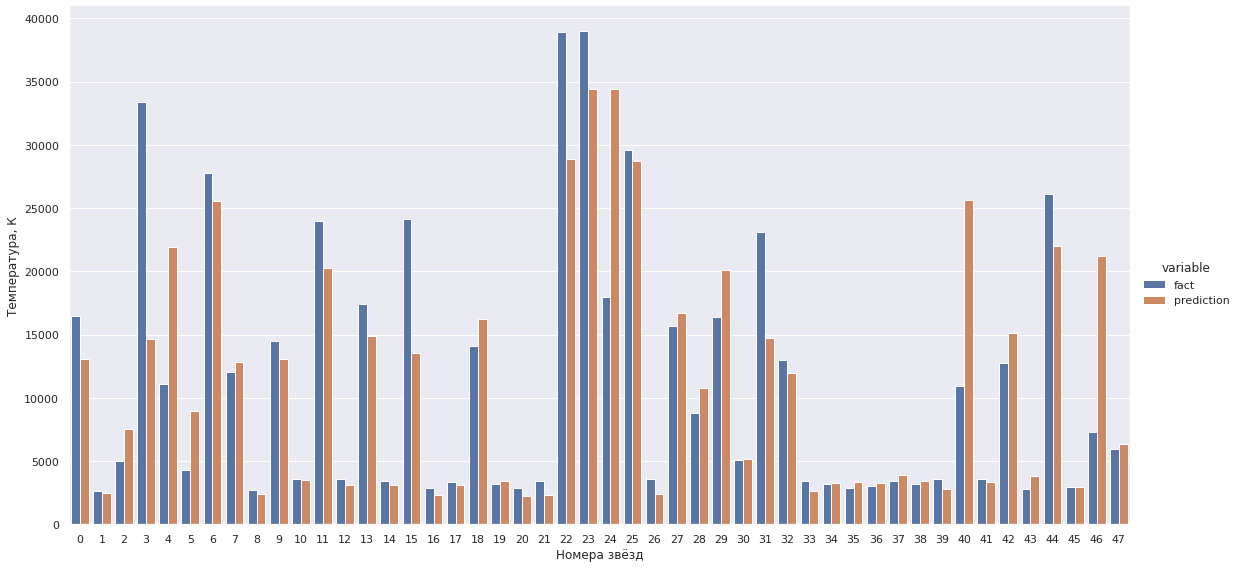

In [55]:
sns.factorplot(
    data=pd.melt(pred_fact.reset_index(), id_vars="index"),
    x="index",
    y="value",
    hue="variable",
    ax=ax,
    kind="bar",
    size=8,
    aspect=2,
).set(xlabel="Номера звёзд", ylabel="Температура, К");

## Выводы¶

В процессе обучения нейронной сети мы начали с простейших моделей с одним и двумя скрытыми слоями, но качество их прогнозов было не достаточным.

Выбрав одну из моделей, со сравнительно произвольной архитектурой, мы, тем не менее, путём подбора параметров регуляризации, смогли повысить качество её прогнозов и добится требуемого качества работы.

Хотя вопросы по подбору базовых архитектурных параметров (количество слоёв и их размеры) всё ещё требуют дальнейшего изучения. 